### 

In [4]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta


In [5]:
# Load file
path = r"Stock_Closing_Prices_10.csv"
stock_data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')

# Time period
start_period = '2020-01-02'
end_period = '2022-12-30'
stock_data = stock_data.loc[start_period:end_period].copy()

# Parameters
buy_fee_rate = 0.0049  # 0.49% buy fee
sell_fee_rate = 0.003  # 0.3% sell fee

initial_investment_amount = 100000 
investment_amount = initial_investment_amount
target_return = 0.02 
daily_target_return = (1 + target_return) ** (1/252) - 1
risk_tolerance = 0.60 
sharpe_coefficient = 0.5 
rebalancing_frequency = 21 
rebalance_dates = stock_data.index[::rebalancing_frequency]
return_coef=1
hist_lag = 378 

# Fill NaN
stock_data.ffill(inplace=True)
stock_data.bfill(inplace=True)

# Define the risk-free rate
annual_risk_free_rate = 0.02  # 2% risk-free rate
trading_days_per_year = 252  # Number of trading days in a year

# Calculate daily risk-free rate
daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1 / trading_days_per_year) - 1

portfolio_performance = []
weights_records = []
investment_records = []
shares_records = []
trade_records = []
hold_records = []


In [6]:
def objective_function(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_risk = np.dot(weights.T, np.dot(cov_matrix, weights))
        sqrt_portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - daily_risk_free_rate) / sqrt_portfolio_risk*np.sqrt(252)
        return portfolio_risk-return_coef*portfolio_return

In [7]:
# Initial holding and investment_amount
hold_matrix = pd.DataFrame(0.0, index=stock_data.index, columns=stock_data.columns)
investment_amount_series = pd.Series(initial_investment_amount, index=stock_data.index, dtype=float)
trade_matrix = pd.DataFrame(0.0, index=stock_data.index, columns=stock_data.columns)

In [8]:
for i, current_date in enumerate(rebalance_dates):
    if i > 0 and portfolio_performance:
        investment_amount += portfolio_performance[-1]['Portfolio Return'] * investment_amount
    start_date = current_date - timedelta(days=hist_lag)
    historical_data = stock_data[(stock_data.index >= start_date) & (stock_data.index <= current_date)].copy()

    historical_data.interpolate(method='linear', inplace=True)
    
    historical_data = historical_data.loc[:, historical_data.isnull().mean() < 0.2]

    if historical_data.empty or len(historical_data.columns) < hist_lag:  
        print(f"Skipping {current_date} due to insufficient data.")
        continue

    # return rate
    ret = np.log(historical_data).diff().dropna(how='all', axis=1)

    # mean & variance
    mean_returns = ret.mean()
    cov_matrix = ret.cov()

    num_assets = len(mean_returns)
    if num_assets == 0:
        print(f"No assets available for optimization at {current_date}. Skipping.")
        continue
    print(f"Optimization at {current_date}. Running.")
    initial_weights = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # print(f"before optimization: {weights}")
    optimized = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if not optimized.success:
        print(f"Optimization failed for {current_date},use previous weights.")

    else:
        weights = optimized.x   

    previous_weights=weights
    # portfolio return, risk and sharpe ratio
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - daily_risk_free_rate) / portfolio_risk* np.sqrt(trading_days_per_year)

    # For each stock: calculate investment amount and # of shares
    latest_prices = historical_data.iloc[-1]
    investment_per_stock = weights * investment_amount
    shares_per_stock = (investment_per_stock / latest_prices).round(2)

    # Calculate trade_matrix and hold_matrix
    if i == 0:
        previous_shares = pd.Series(0, index=historical_data.columns)
    else:
        previous_shares = hold_matrix.loc[rebalance_dates[i - 1]]
    trades = shares_per_stock - previous_shares
    trade_matrix.loc[current_date, trades.index] = trades
 
    # Update holding
    hold_matrix.loc[current_date, trades.index] = shares_per_stock

    # Calculate transaction fee and update investment amount with returns and fees
    sell_trades = trades[trades < 0]
    buy_trades = trades[trades > 0]
    sell_cost = (-sell_trades * latest_prices.loc[sell_trades.index] * sell_fee_rate).sum()
    buy_cost = (buy_trades * latest_prices.loc[buy_trades.index] * buy_fee_rate).sum()
    investment_amount -= (sell_cost + buy_cost)

    if i > 0:
        prev_date = rebalance_dates[i - 1]
        hold_matrix.loc[prev_date:current_date - timedelta(days=1)] = hold_matrix.loc[prev_date].values
        investment_amount_series.loc[rebalance_dates[i - 1]:current_date - timedelta(days=1)] = investment_amount_series.loc[rebalance_dates[i - 1]]
    investment_amount_series.loc[current_date] = investment_amount

    # if shares_per_stock is too small, then adjust it
    significant_shares_mask = (shares_per_stock * 100).astype(int) > 0
    if not significant_shares_mask.all():
        significant_weights = weights[significant_shares_mask]
        total_significant_weight = significant_weights.sum()
        adjusted_weights = significant_weights / total_significant_weight
        adjusted_investment_per_stock = adjusted_weights * investment_amount
        adjusted_shares_per_stock = (adjusted_investment_per_stock / latest_prices[significant_shares_mask] * 100).round(2)

        weights = adjusted_weights
        investment_per_stock = adjusted_investment_per_stock
        shares_per_stock = adjusted_shares_per_stock
        historical_data = historical_data.loc[:, significant_shares_mask]
        
    # portfolio details
    weights_records.append(pd.Series(weights, index=historical_data.columns, name=current_date))
    investment_records.append(pd.Series(investment_per_stock, index=historical_data.columns, name=current_date))
    shares_records.append(pd.Series(shares_per_stock, index=historical_data.columns, name=current_date))

    portfolio_performance.append({
        'Date': current_date,
        'Portfolio Return': portfolio_return,
        'Portfolio Risk': portfolio_risk,
        'Sharpe Ratio': sharpe_ratio
    })

No assets available for optimization at 2020-01-02 00:00:00. Skipping.
Optimization at 2020-02-03 00:00:00. Running.
Optimization at 2020-03-04 00:00:00. Running.
Optimization at 2020-04-02 00:00:00. Running.
Optimization at 2020-05-04 00:00:00. Running.
Optimization at 2020-06-03 00:00:00. Running.
Optimization at 2020-07-02 00:00:00. Running.
Optimization at 2020-08-03 00:00:00. Running.
Optimization at 2020-09-01 00:00:00. Running.
Optimization at 2020-10-01 00:00:00. Running.
Optimization at 2020-10-30 00:00:00. Running.
Optimization at 2020-12-01 00:00:00. Running.
Optimization at 2020-12-31 00:00:00. Running.
Optimization at 2021-02-02 00:00:00. Running.
Optimization at 2021-03-04 00:00:00. Running.
Optimization at 2021-04-05 00:00:00. Running.
Optimization at 2021-05-04 00:00:00. Running.
Optimization at 2021-06-03 00:00:00. Running.
Optimization at 2021-07-02 00:00:00. Running.
Optimization at 2021-08-03 00:00:00. Running.
Optimization at 2021-09-01 00:00:00. Running.
Optimizat

In [9]:
# For the last rebalancing date
for date in hold_matrix.loc[rebalance_dates[-1]:].index:
    hold_matrix.loc[date] = hold_matrix.loc[rebalance_dates[-1]].values
    investment_amount_series.loc[date] = investment_amount_series.loc[rebalance_dates[-1]]

In [10]:
portfolio_df = pd.DataFrame(portfolio_performance).set_index('Date')


In [11]:
weights_df = pd.DataFrame(weights_records)
investment_df = pd.DataFrame(investment_records)
shares_df = pd.DataFrame(shares_records)


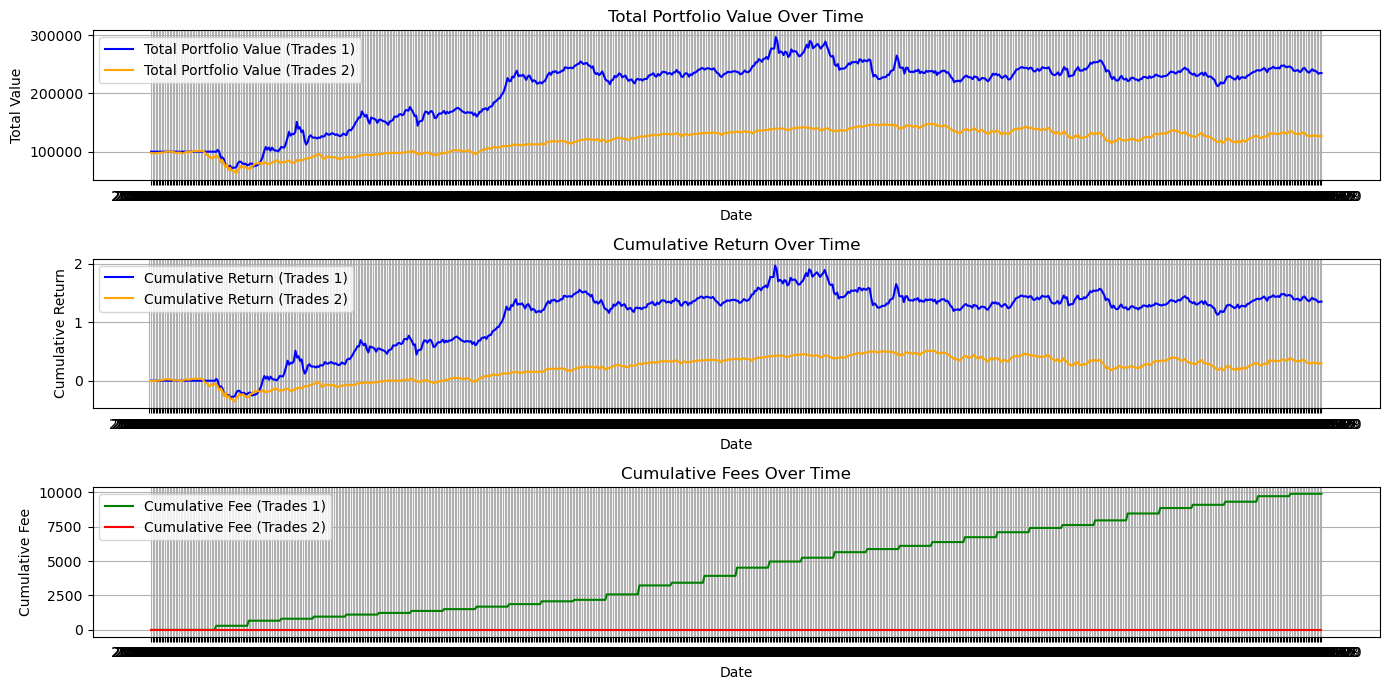

--- Holdings1 ---
Annual Return (Trades 1): 0.3297
Excess Return (Trades 1): 0.3097
Annualized Volatility (Trades 1): 0.3566
Sharpe Ratio (Trades 1): 0.8684
Maximum Drawdown (Trades 1): -30.69%

--- Holdings2 ---
Annual Return (Trades 2): 0.0908
Excess Return (Trades 2): 0.0708
Annualized Volatility (Trades 2): 0.2623
Sharpe Ratio (Trades 2): 0.2700
Maximum Drawdown (Trades 2): -37.98%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)  # For reproducibility

# Load historical stock data
file_path = 'Stock_Closing_Prices_10.csv' 
data = pd.read_csv(file_path, parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = data.index.strftime('%Y-%m-%d')
# Load trade decision matrix
start_period = '2020-01-02'
end_period = '2022-12-30'

data = data.loc[(data.index >= start_period) & (data.index <= end_period)]

# Define the stock list and date range
stock_list=data.columns.tolist()
date_range = data.index.unique()

# Create the holdings DataFrame
holdings1 = pd.DataFrame(0.0, index=date_range, columns=stock_list + ['cash', 'fee', 'cumulative_fee'])
holdings2 = pd.DataFrame(0.0, index=date_range, columns=stock_list + ['cash', 'fee', 'cumulative_fee'])

# Initialize cash and cumulative fees
holdings1.iloc[0, -3] = 100000.0  # Initial cash for trades1
holdings2.iloc[0, -3] = 0  # Initial cash for trades2
holdings1.iloc[0, :-3] = 0 # Initial holdings for trades1
holdings2.iloc[0, :-3] = 100000.0/500/data.iloc[0]  # Initial holdings for trades2

buy_fee_rate = 0.0049  # 0.49% buy fee
sell_fee_rate = 0.003  # 0.3% sell fee

# Extract the closing prices
close_prices = data[stock_list]

# Create trade decision matrices trades1 and trades2
trades1 = pd.DataFrame(0, index=close_prices.index, columns=stock_list)
trades2 = pd.DataFrame(0, index=close_prices.index, columns=stock_list)


# Load the CSV file and set 'Date' as the index
trades1 = trade_matrix
trades2 = pd.DataFrame(np.random.choice([0, 0, 0], size=(len(date_range), len(stock_list))), 
                    index=date_range, 
                    columns=stock_list)

# Process trades for trades1
for date in date_range:
    # print(f'processing date:{date} ')
    if date == date_range[0]:
        holdings1.loc[date, 'cash'] = 100000.0  # Initial cash
        holdings1.loc[date, 'fee'] = 0.0
        holdings1.loc[date, 'cumulative_fee'] = 0.0
    else:
        previous_date = date_range[date_range.get_loc(date) - 1]  # Find previous date
        holdings1.loc[date, ['cash'] + stock_list + ['fee', 'cumulative_fee']] = holdings1.loc[previous_date, ['cash'] + stock_list + ['fee', 'cumulative_fee']]  # Copy previous data

    for stock in stock_list:
        trade = trades1.loc[date, stock]
        cost = trade * close_prices.loc[date, stock]
        
        # Handle buying
        if trade > 0:
            if holdings1.loc[date, 'cash'] >= (cost + abs(trade) * close_prices.loc[date, stock] * buy_fee_rate):  # Check if enough cash
                fee = abs(trade) * close_prices.loc[date, stock] * buy_fee_rate
                holdings1.loc[date, 'cash'] -= (cost + fee)  # Deduct total cost including fee
                holdings1.loc[date, stock] += trade  # Update stock holdings
                holdings1.loc[date, 'fee'] += fee  # Update fee


        # Handle selling
        elif trade < 0:
            if holdings1.loc[date, stock] + trade >= 0:  # Check if enough shares
                holdings1.loc[date, stock] += trade
                holdings1.loc[date, 'cash'] += abs(trade) * close_prices.loc[date, stock]
                fee = abs(trade) * close_prices.loc[date, stock] * sell_fee_rate  # Calculate sell fee
                holdings1.loc[date, 'cash'] -= fee  # Deduct fee from cash
                holdings1.loc[date, 'fee'] += fee  # Update fee


# Process trades for trades2 (similar to trades1)
for date in date_range:
    if date == date_range[0]:
        holdings2.loc[date, 'cash'] = 0  # Initial cash
        holdings2.loc[date, 'fee'] = 0.0
        holdings2.loc[date, 'cumulative_fee'] = 0.0
    else:
        previous_date = date_range[date_range.get_loc(date) - 1]  # Find previous date
        holdings2.loc[date, ['cash'] + stock_list + ['fee', 'cumulative_fee']] = holdings2.loc[previous_date, ['cash'] + stock_list + ['fee', 'cumulative_fee']]  # Copy previous data

    for stock in stock_list:
        trade = trades2.loc[date, stock]
        cost = trade * close_prices.loc[date, stock]

        # Handle buying
        if trade > 0:
            if holdings2.loc[date, 'cash'] >= (cost + abs(trade) * close_prices.loc[date, stock] * buy_fee_rate):  # Check if enough cash
                fee = abs(trade) * close_prices.loc[date, stock] * buy_fee_rate
                holdings2.loc[date, 'cash'] -= (cost + fee)  # Deduct total cost including fee
                holdings2.loc[date, stock] += trade  # Update stock holdings
                holdings2.loc[date, 'fee'] += fee  # Update fee


        # Handle selling
        elif trade < 0:
            if holdings2.loc[date, stock] + trade >= 0:  # Check if enough shares
                holdings2.loc[date, stock] += trade
                holdings2.loc[date, 'cash'] += abs(trade) * close_prices.loc[date, stock]
                fee = abs(trade) * close_prices.loc[date, stock] * sell_fee_rate  # Calculate sell fee
                holdings2.loc[date, 'cash'] -= fee  # Deduct fee from cash
                holdings2.loc[date, 'fee'] += fee  # Update fee


# Calculate total value for both trades
holdings1['total_value'] = (holdings1[stock_list] * close_prices[stock_list]).sum(axis=1) + holdings1['cash']
holdings2['total_value'] = (holdings2[stock_list] * close_prices[stock_list]).sum(axis=1) + holdings2['cash']

initial_value = sum(holdings1.iloc[0][stock] * close_prices.loc[date_range[0], stock] for stock in stock_list) + holdings1.iloc[0]['cash']
# Calculate daily returns for both trades
holdings1['portfolio_value'] = holdings1['total_value'].shift(1).fillna(initial_value)
holdings1['return'] = (holdings1['total_value'] / holdings1['portfolio_value']) - 1

holdings2['portfolio_value'] = holdings2['total_value'].shift(1).fillna(initial_value)
holdings2['return'] = (holdings2['total_value'] / holdings2['portfolio_value']) - 1

# Calculate cumulative returns
holdings1['cumulative_return'] = (1 + holdings1['return']).cumprod() - 1
holdings2['cumulative_return'] = (1 + holdings2['return']).cumprod() - 1

trades1.to_csv('trades1.csv')
holdings1.to_csv('holdings1.csv')

# Plotting
plt.figure(figsize=(14, 7))

# Plot total value for trades1
plt.subplot(3, 1, 1)
plt.plot(holdings1.index, holdings1['total_value'], label='Total Portfolio Value (Trades 1)', color='blue')
plt.plot(holdings2.index, holdings2['total_value'], label='Total Portfolio Value (Trades 2)', color='orange')
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.grid()
plt.legend()

# Plot cumulative returns for both trades
plt.subplot(3, 1, 2)
plt.plot(holdings1.index, holdings1['cumulative_return'], label='Cumulative Return (Trades 1)', color='blue')
plt.plot(holdings2.index, holdings2['cumulative_return'], label='Cumulative Return (Trades 2)', color='orange')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid()
plt.legend()

# Plot cumulative fees for both trades
plt.subplot(3, 1, 3)
plt.plot(holdings1.index, holdings1['fee'], label='Cumulative Fee (Trades 1)', color='green')
plt.plot(holdings2.index, holdings2['fee'], label='Cumulative Fee (Trades 2)', color='red')
plt.title('Cumulative Fees Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Fee')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Update cumulative fee for the current date

trading_days_per_year = 252
# Define the annual risk-free rate
annual_risk_free_rate = 2 / 100  # 3% annual risk-free rate

# For holdings1
# Calculate annual return based on cumulative return at the end
annual_return1 = (1 + holdings1['cumulative_return'].iloc[-1]) ** (trading_days_per_year / len(holdings1['cumulative_return'])) - 1
# Calculate excess annual return
excess_return1 = annual_return1 - annual_risk_free_rate

# Calculate the standard deviation of daily returns and annualize it
daily_return_std1 = holdings1['return'].std()
annualized_volatility1 = daily_return_std1 * np.sqrt(trading_days_per_year)

# Calculate the annualized Sharpe ratio
sharpe_ratio_trades1 = excess_return1 / annualized_volatility1
######################
# For holdings2
# Calculate annual return based on cumulative return at the end
annual_return2 = (1 + holdings2['cumulative_return'].iloc[-1]) ** (trading_days_per_year / len(holdings2['cumulative_return'])) - 1
# Calculate excess annual return
excess_return2 = annual_return2 - annual_risk_free_rate

# Calculate the standard deviation of daily returns and annualize it
daily_return_std2 = holdings2['return'].std()
annualized_volatility2 = daily_return_std2 * np.sqrt(trading_days_per_year)

# Calculate the annualized Sharpe ratio
sharpe_ratio_trades2 = excess_return2 / annualized_volatility2



# Calculate the rolling maximum of the total value for both portfolios
holdings1['rolling_max'] = holdings1['total_value'].cummax()
holdings2['rolling_max'] = holdings2['total_value'].cummax()

# Calculate drawdowns for both portfolios
holdings1['drawdown'] = (holdings1['total_value'] - holdings1['rolling_max']) / holdings1['rolling_max']
holdings2['drawdown'] = (holdings2['total_value'] - holdings2['rolling_max']) / holdings2['rolling_max']

# Calculate the maximum drawdown
max_drawdown1 = holdings1['drawdown'].min()
max_drawdown2 = holdings2['drawdown'].min()


# Display results for both trading strategies
print(f"--- Holdings1 ---")
print(f"Annual Return (Trades 1): {annual_return1:.4f}")
print(f"Excess Return (Trades 1): {excess_return1:.4f}")
print(f"Annualized Volatility (Trades 1): {annualized_volatility1:.4f}")
print(f"Sharpe Ratio (Trades 1): {sharpe_ratio_trades1:.4f}")
print(f"Maximum Drawdown (Trades 1): {max_drawdown1:.2%}")

print(f"\n--- Holdings2 ---")
print(f"Annual Return (Trades 2): {annual_return2:.4f}")
print(f"Excess Return (Trades 2): {excess_return2:.4f}")
print(f"Annualized Volatility (Trades 2): {annualized_volatility2:.4f}")
print(f"Sharpe Ratio (Trades 2): {sharpe_ratio_trades2:.4f}")
print(f"Maximum Drawdown (Trades 2): {max_drawdown2:.2%}")
######################
# Calculate cash proportion for both portfolios
holdings1['cash_proportion'] = holdings1['cash'] / holdings1['total_value']
holdings2['cash_proportion'] = holdings2['cash'] / holdings2['total_value']


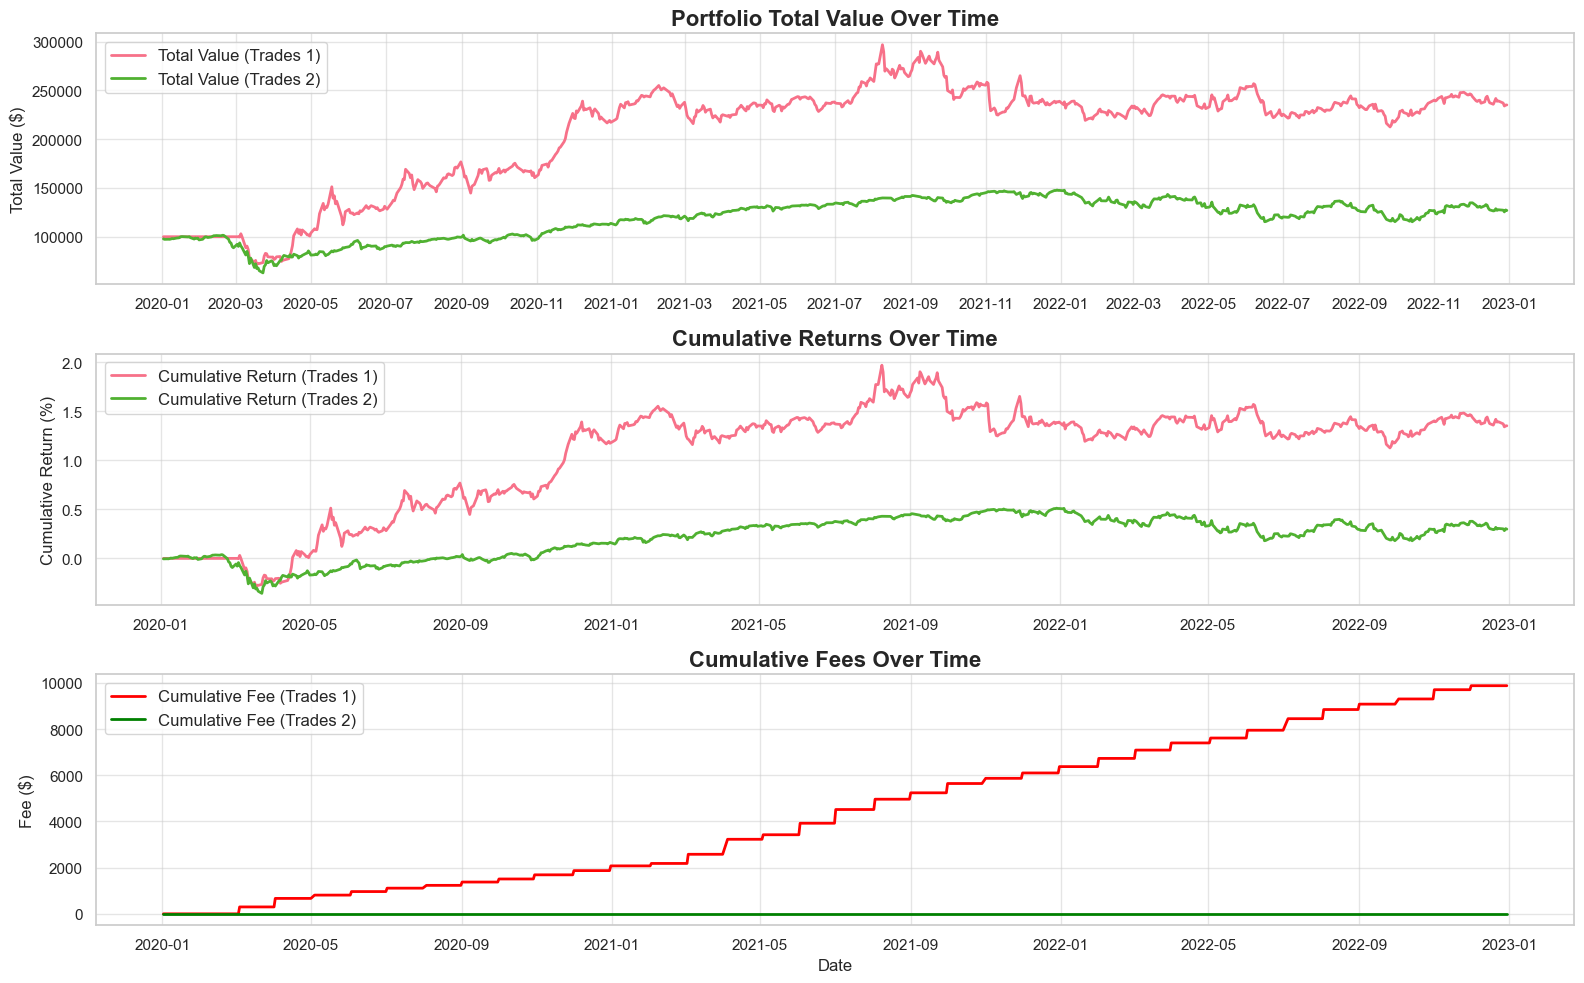

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
holdings1.index = pd.to_datetime(holdings1.index)
holdings2.index = pd.to_datetime(holdings2.index)

#style
sns.set_theme(style="whitegrid")

# set color palette
palette = sns.color_palette("husl", 3)

# set figure size
plt.figure(figsize=(16, 10))

# plot portfolio total value and cumulative return over time
plt.subplot(3, 1, 1)
plt.plot(holdings1.index, holdings1['total_value'], label='Total Value (Trades 1)', color=palette[0], lw=2)
plt.plot(holdings2.index, holdings2['total_value'], label='Total Value (Trades 2)', color=palette[1], lw=2)
plt.title('Portfolio Total Value Over Time', fontsize=16, fontweight='bold')
plt.ylabel('Total Value ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# plot cumulative return over time
plt.subplot(3, 1, 2)
plt.plot(holdings1.index, holdings1['cumulative_return'], label='Cumulative Return (Trades 1)', color=palette[0], lw=2)
plt.plot(holdings2.index, holdings2['cumulative_return'], label='Cumulative Return (Trades 2)', color=palette[1], lw=2)
plt.title('Cumulative Returns Over Time', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plot cumulative fee over time
plt.subplot(3, 1, 3)
plt.plot(holdings1.index, holdings1['fee'], label='Cumulative Fee (Trades 1)', color='red', lw=2)
plt.plot(holdings2.index, holdings2['fee'], label='Cumulative Fee (Trades 2)', color='green', lw=2)
plt.title('Cumulative Fees Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fee ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()


